In [1]:
!which python

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/bin/python


In [2]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [3]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [5]:
vcfutils = "vcfutils.pl"
vcftools = "vcftools"
bcftools = "bcftools"
bgzip = "bgzip"
tabix = "tabix"
java = "java"
plink = "plink --noweb"

In [6]:
analysis_dir = '/data/gpfs/assoc/denovo/PHHA/ddocent/filtering/'

In [7]:
cd $analysis_dir

/data/gpfs/assoc/denovo/PHHA/ddocent/filtering


In [8]:
vcf_file = os.path.join(analysis_dir, "TotalRawSNPs.vcf.gz")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/assoc/denovo/PHHA/ddocent/filtering/TotalRawSNPs.vcf.gz'

## keep only biallelic first

In [10]:
!$vcftools --remove-indels \
--min-alleles 2 \
--max-alleles 2 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_file \
--out $'PHHA.biallelic'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/TotalRawSNPs.vcf.gz
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--out PHHA.biallelic
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 256 out of 256 Individuals
Outputting VCF file...
After filtering, kept 775804 out of a possible 1113694 Sites
Run Time = 646.00 seconds


In [11]:
vcf_biallelic = os.path.join(analysis_dir, "PHHA.biallelic.recode.vcf")
vcf_biallelic_gz = vcf_biallelic + '.gz'
!$bgzip -c $vcf_biallelic > {vcf_biallelic_gz}
!$tabix {vcf_biallelic_gz}

## Remove by MAF, missing, and thin next

In [12]:
!$vcftools \
--max-missing 0.6 \
--maf 0.02 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_biallelic_gz \
--out $'PHHA_miss60_thin100_MAF2'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/PHHA.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.02
	--thin 100
	--max-missing 0.6
	--out PHHA_miss60_thin100_MAF2
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 256 out of 256 Individuals
Outputting VCF file...
After filtering, kept 33703 out of a possible 775804 Sites
Run Time = 68.00 seconds


In [13]:
!$vcftools \
--max-missing 0.7 \
--maf 0.02 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_biallelic_gz \
--out $'PHHA_miss70_thin100_MAF2'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/PHHA.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.02
	--thin 100
	--max-missing 0.7
	--out PHHA_miss70_thin100_MAF2
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 256 out of 256 Individuals
Outputting VCF file...
After filtering, kept 28114 out of a possible 775804 Sites
Run Time = 63.00 seconds


In [14]:
vcf_filtered = "PHHA_miss70_thin100_MAF2.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [15]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Remove bad_indv


In [16]:
!$vcftools --gzvcf $vcf_filtered_gz --out $vcf_filtered_gz --missing-indv


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf PHHA_miss70_thin100_MAF2.recode.vcf.gz
	--missing-indv
	--out PHHA_miss70_thin100_MAF2.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 256 out of 256 Individuals
Outputting Individual Missingness
After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 1.00 seconds


In [17]:
def get_imiss(vcf_file):
    imiss_file = !ls {vcf_file}.imiss
    imiss_df = pd.read_csv(imiss_file[0], sep="\t")
    imiss_df.index = imiss_df.INDV
    return imiss_df

In [18]:
imiss_df = get_imiss(vcf_filtered_gz)
imiss_df.head()

,INDV,N_DATA,N_GENOTYPES_FILTERED,N_MISS,F_MISS
INDV,,,,,
PH_AS_10,PH_AS_10,28114,0,953,0.033898
PH_AS_11,PH_AS_11,28114,0,2671,0.095006
PH_AS_12,PH_AS_12,28114,0,1788,0.063598
PH_AS_1,PH_AS_1,28114,0,1842,0.065519
PH_AS_2,PH_AS_2,28114,0,590,0.020986


In [19]:
imiss_df.F_MISS.describe()

count    256.000000
mean       0.121079
std        0.139689
min        0.012165
25%        0.063171
50%        0.080476
75%        0.132114
max        0.996230
Name: F_MISS, dtype: float64

In [21]:
len(imiss_df),len(imiss_df[imiss_df.F_MISS >= .5]),len(imiss_df[imiss_df.F_MISS >= .4]), len(imiss_df[imiss_df.F_MISS >= .25])


(256, 7, 10, 12)

In [22]:
bad_indv = imiss_df.INDV[imiss_df.F_MISS >= .25]

In [23]:
with open(os.path.join(analysis_dir, "bad_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in bad_indv.index:
        o.write("%s\n" % elem)

In [24]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "bad_indv.txt")} \
--out {os.path.join(analysis_dir, "snps_indv_removed")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf PHHA_miss70_thin100_MAF2.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/bad_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 244 out of 256 Individuals
Outputting VCF file...
After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 23.00 seconds


In [25]:
vcf_bad_remove = os.path.join(analysis_dir, "snps_indv_removed.recode.vcf")
vcf_bad_remove_gz = vcf_bad_remove + ".gz"
!$bgzip -c {vcf_bad_remove} > {vcf_bad_remove_gz}
!$tabix {vcf_bad_remove_gz}

# Filter snps further 
this needs to be done after removing individuals


In [26]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [27]:
get_vcf_stats(vcf_bad_remove_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--depth
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting Mean Depth by Individual
After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--site-depth

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting Depth for Each Site


After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--site-mean-depth

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting Depth for Each Site
After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--site-quality

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting Quality for Each Site


After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--missing-site

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting Site Missingness
After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--freq
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting Frequency Statistics...


After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--counts
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting Frequency Statistics...
After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--hardy
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting HWE statistics (but only for biallelic loci)


After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 2.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--het
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting Individual Heterozygosity
After filtering, kept 28114 out of a possible 28114 Sites
Run Time = 2.00 seconds


In [28]:
#pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [29]:
vcf_bad_remove_gz

'/data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz'

In [30]:
loci_df, frq_df, hardy = combine_vcf_stats(analysis_dir,'snps_indv_removed.recode.vcf.gz')

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


RangeIndex(start=0, stop=6, step=1)


In [31]:
loci_df

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,QUAL,N_ALLELES,...,ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
dDocent_Contig_123-64,341959,1726515051,1401.47000,5.132800e+06,488,0,0,0.000000,6458.970,2,...,18.787750,6.680879e-07,1.000000e+00,3.970073e-07,T,G,0.782787,0.217213,0.217213,-0.274869
dDocent_Contig_237-19,417634,917890644,1711.61000,8.356470e+05,488,0,0,0.000000,814738.000,2,...,186.190600,2.141909e-20,2.141909e-20,1.000000e+00,A,C,0.930328,0.069672,0.069672,0.873802
dDocent_Contig_278-64,435505,1112584829,1784.86000,1.379720e+06,488,0,0,0.000000,289669.000,2,...,89.268270,2.421640e-06,2.421640e-06,1.000000e+00,T,C,0.973361,0.026639,0.026639,0.605668
dDocent_Contig_326-42,380410,1123095298,1559.06000,2.181130e+06,488,0,0,0.000000,26641.100,2,...,0.317867,1.000000e+00,1.000000e+00,7.493871e-01,C,T,0.965164,0.034836,0.034836,-0.033970
dDocent_Contig_330-22,362256,719827618,1484.66000,7.489800e+05,488,0,0,0.000000,641078.000,2,...,145.672900,1.730150e-14,1.730150e-14,1.000000e+00,C,A,0.942623,0.057377,0.057377,0.773137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dDocent_Contig_441023-46,1728,23932,8.26794,4.637020e+01,488,0,70,0.143443,538.412,2,...,0.152666,1.000000e+00,1.000000e+00,8.737299e-01,G,T,0.973684,0.026316,0.026316,-0.024570
dDocent_Contig_441052-5,1484,19126,7.64948,4.028060e+01,488,0,100,0.204918,708.045,2,...,0.197601,1.000000e+00,1.000000e+00,8.391836e-01,A,T,0.969072,0.030928,0.030928,-0.029255
dDocent_Contig_441078-18,728,3884,3.65829,6.165470e+00,488,0,90,0.184426,335.542,2,...,64.623930,1.872976e-06,1.872976e-06,1.000000e+00,C,T,0.957286,0.042714,0.042714,0.570943
dDocent_Contig_441136-5,857,6041,4.65761,1.119910e+01,488,0,120,0.245902,685.675,2,...,113.507600,9.809512e-13,9.809512e-13,1.000000e+00,A,C,0.932065,0.067935,0.067935,0.786006


In [32]:
frq_df

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
dDocent_Contig_123-64,dDocent_Contig_123,64,2,488,T:0.782787,G:0.217213
dDocent_Contig_237-19,dDocent_Contig_237,19,2,488,A:0.930328,C:0.0696721
dDocent_Contig_278-64,dDocent_Contig_278,64,2,488,T:0.973361,C:0.0266393
dDocent_Contig_326-42,dDocent_Contig_326,42,2,488,C:0.965164,T:0.0348361
dDocent_Contig_330-22,dDocent_Contig_330,22,2,488,C:0.942623,A:0.057377
...,...,...,...,...,...,...
dDocent_Contig_441023-46,dDocent_Contig_441023,46,2,418,G:0.973684,T:0.0263158
dDocent_Contig_441052-5,dDocent_Contig_441052,5,2,388,A:0.969072,T:0.0309278
dDocent_Contig_441078-18,dDocent_Contig_441078,18,2,398,C:0.957286,T:0.0427136
dDocent_Contig_441136-5,dDocent_Contig_441136,5,2,368,A:0.932065,C:0.0679348


In [33]:
hardy

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
dDocent_Contig_123-64,dDocent_Contig_123,64,138/106/0,149.51/82.98/11.51,18.787750,6.680879e-07,1.000000e+00,3.970073e-07
dDocent_Contig_237-19,dDocent_Contig_237,19,225/4/15,211.18/31.63/1.18,186.190600,2.141909e-20,2.141909e-20,1.000000e+00
dDocent_Contig_278-64,dDocent_Contig_278,64,235/5/4,231.17/12.65/0.17,89.268270,2.421640e-06,2.421640e-06,1.000000e+00
dDocent_Contig_326-42,dDocent_Contig_326,42,227/17/0,227.30/16.41/0.30,0.317867,1.000000e+00,1.000000e+00,7.493871e-01
dDocent_Contig_330-22,dDocent_Contig_330,22,227/6/11,216.80/26.39/0.80,145.672900,1.730150e-14,1.730150e-14,1.000000e+00
...,...,...,...,...,...,...,...,...
dDocent_Contig_441023-46,dDocent_Contig_441023,46,198/11/0,198.14/10.71/0.14,0.152666,1.000000e+00,1.000000e+00,8.737299e-01
dDocent_Contig_441052-5,dDocent_Contig_441052,5,182/12/0,182.19/11.63/0.19,0.197601,1.000000e+00,1.000000e+00,8.391836e-01
dDocent_Contig_441078-18,dDocent_Contig_441078,18,187/7/5,182.36/16.27/0.36,64.623930,1.872976e-06,1.872976e-06,1.000000e+00
dDocent_Contig_441136-5,dDocent_Contig_441136,5,169/5/10,159.85/23.30/0.85,113.507600,9.809512e-13,9.809512e-13,1.000000e+00


In [34]:
loci_out = os.path.join(analysis_dir,'loci_out.csv')
frq_out = os.path.join(analysis_dir,'frq_out.csv')
hardy_out = os.path.join(analysis_dir,'hardy_out.csv')

loci_df.to_csv(path_or_buf=loci_out)
frq_df.to_csv(path_or_buf=frq_out)
hardy.to_csv(path_or_buf=hardy_out)


In [39]:
loci_df.MEAN_DEPTH.describe()

count    28114.000000
mean        13.328822
std         43.110074
min          2.791440
25%          5.885430
50%          7.888365
75%         11.459975
max       1784.860000
Name: MEAN_DEPTH, dtype: float64

In [40]:
loci_df.QUAL.describe()

count    2.811400e+04
mean     3.309517e+03
std      2.453001e+04
min      0.000000e+00
25%      4.515400e+02
50%      9.979610e+02
75%      2.563517e+03
max      2.331460e+06
Name: QUAL, dtype: float64

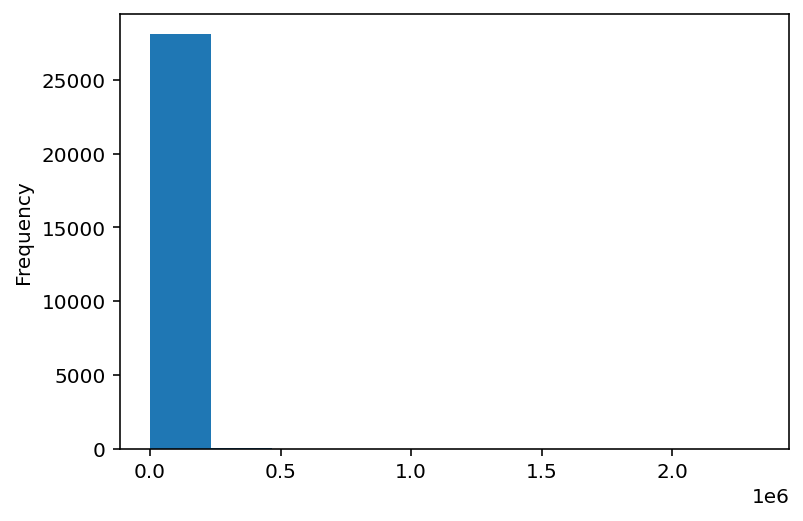

In [41]:
loci_df.QUAL.plot(kind="hist");

In [42]:
len(loci_df[loci_df.Fis == -9])

0

In [43]:
len(loci_df[loci_df.SUM_DEPTH <5000]),len(loci_df[loci_df.SUM_DEPTH >=500])

(25909, 28114)

In [44]:
len(loci_df[loci_df.MEAN_DEPTH > 30]),len(loci_df[loci_df.MEAN_DEPTH >= 3])

(1224, 28103)

In [45]:
len(loci_df[loci_df.QUAL >= 10]) - len(loci_df[loci_df.QUAL >= 20])

118

In [46]:
len(loci_df[loci_df.QUAL <  200]), len(loci_df[loci_df.QUAL < 100]), len(loci_df[loci_df.QUAL < 20])

(2747, 1534, 884)

In [47]:
 len(loci_df[loci_df.Fis <= -0.5]), len(loci_df[loci_df.MAF < 0.02])

(52, 364)

In [48]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.MEAN_DEPTH >= 3) & 
                  (df.MEAN_DEPTH < 30) & 
                  (df.QUAL >= 200) & 
                  (df.MAF >= 0.02) &  
                  (df.Fis > -0.5)]

In [49]:
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(23884, 25)

In [50]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [51]:
!$vcftools --gzvcf $vcf_bad_remove_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "stage1_positions.txt")} \
--out {os.path.join(analysis_dir, "good_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/snps_indv_removed.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/good_snps
	--positions /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting VCF file...
After filtering, kept 23884 out of a possible 28114 Sites
Run Time = 20.00 seconds


In [52]:
snps = os.path.join(analysis_dir, "good_snps.recode.vcf")
snps_gz = snps + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

# Make 012

In [53]:
f = os.path.join(analysis_dir, "good_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/good_snps.recode.vcf
	--012
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/good_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 23884 out of a possible 23884 Sites
Run Time = 2.00 seconds


# Get coverage per individual

In [54]:
f = os.path.join(analysis_dir, "good_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/good_snps.recode.vcf
	--depth
	--out /data/gpfs/assoc/denovo/PHHA/ddocent/filtering/good_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 244 out of 244 Individuals
Outputting Mean Depth by Individual
After filtering, kept 23884 out of a possible 23884 Sites
Run Time = 1.00 seconds


In [55]:
depth_file = os.path.join(analysis_dir, "good_snps.recode.vcf.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,PH_AS_10,23089,11.10270
1,PH_AS_11,21646,7.03973
2,PH_AS_12,22343,11.92390
3,PH_AS_1,22326,12.13930
4,PH_AS_2,23398,10.37370


In [56]:
depth_df.MEAN_DEPTH.describe()

count    244.000000
mean       9.396647
std        2.079223
min        4.394690
25%        7.953965
50%        9.401110
75%       10.909300
max       19.157400
Name: MEAN_DEPTH, dtype: float64

# Remove unnecessary files

In [57]:
!rm snps*

In [58]:
!rm *miss*

In [59]:
!rm *vcf